##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gaussian Process Latent Variable Models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Latent variable models attempt to capture hidden structure in high dimensional
data. Examples include principle component analysis (PCA) and factor analysis.
Gaussian processes are "non-parametric" models which can flexibly capture local
correlation structure and uncertainty. The Gaussian process latent variable
model ([Lawrence, 2004][Lawrence2004]) combines these concepts.

## Background: Gaussian Processes
A Gaussian process is any collection of random variables such that the marginal
distribution over any finite subset is a multivariate normal distribution. For
a detailed look at GPs in the context of regression, check out
[Gaussian Process Regression in TensorFlow Probability][GPRITFP].

We use a so-called *index set* to label each of the random variables in the
collection that the GP comprises. In the case of a finite index set, we just
get a multivariate normal. GP's are most interesting, though, when we consider
*infinite* collections. In the case of index sets like $\mathbb{R}^D$, where we
have a random variable for *every point in $D$-dimensional space*, the GP can be
thought of as a distribution over random *functions*. A single draw from such a
GP, if it could be realized, would assign a (jointly normally-distributed) value
to every point in $\mathbb{R}^D$. In this colab, we'll focus on GP's over some
$\mathbb{R}^D$.

Normal distributions are completely determined by their first and second order
statistics -- indeed, one way to define the normal distribution is as one whose
higher-order cumulants are all zero. This is the case for GP's, too: we completely
specify a GP by describing the mean and covariance<sup>*</sup>. Recall that for
finite-dimensional multivariate normals, the mean is a vector and the covariance is a square,
symmetric positive-definite matrix. In the infinite-dimensional GP, these
structures generalize to a mean *function* $m : \mathbb{R}^D \to \mathbb{R}$,
defined at each point of the index set, and a covariance "*kernel*" function,
$k : \mathbb{R}^D \times \mathbb{R}^D \to \mathbb{R}$. The kernel
function is required to be [positive-definite][PositiveDefiniteFunction], which
essentially says that, restricted to a finite set of points, it yields a
postiive-definite matrix.

Most of the structure of a GP derives from its covariance kernel function --
this function describes how the values of sampeld functions vary across nearby
(or not-so-nearby) points. Different covariance functions encourage different
degrees of smoothness. One commonly used kernel function is the "exponentiated
quadratic" (a.k.a., "gaussian", "squared exponential" or "radial basis
function"), $k(x, x') = \sigma^2 e^{(x - x^2) / \lambda^2}$. Other examples
are outlined on David Duvenaud's [kernel cookbook page][KernelCookbook], as well
as in the canonical text [Gaussian Processes for Machine Learning][GPsForML].

[Lawrence2004]: https://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf
[GPRITFP]: https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb
[KernelCookbook]: https://www.cs.toronto.edu/~duvenaud/cookbook/
[PositiveDefiniteFunction]: https://en.wikipedia.org/wiki/Positive-definite_function
[GPsForML]: http://www.gaussianprocess.org/gpml/

 <sub>\* With an infinite index set, we also require a consistency condition. Since
 the definition of the GP is in terms of finite marginals, we must require that
 these marginals are consistent irrespective of the order in which the
 marginals are taken. This is a somewhat advanced topic in the theory of
 stochastic processes, out of scope for this tutorial; suffice it to say things
 work out ok in the end!</sub>

##  Applying GPs: Regression and Latent Variable Models

One way we can use GPs is for regression: given a bunch of observed data in the
form of inputs $\{x_i\}_{i=1}^N$ (elements of the index set) and observations
$\{y_i\}_{i=1}^N$, we can use these to form a posterior predictive distribution
at a new set of points $\{x_j^*\}_{j=1}^M$. Since the distributions are all
Gaussian, this boils down to some straightforward linear algebra (but note: the
requisite computations have runtime *cubic* in the number of data points and
require space quadratic in the number of data points -- this is a major limiting
factor in the use of GPs and much current research focuses on computationally
viable alternatives to exact posterior inference). We cover GP regression in more
detail in the [GP Regression in TFP colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb).


Another way we can use GPs is as a latent variable model: given a collection of
high-dimensional observations (e.g., images), we can posit some low-dimensional
latent structure. We assume that, conditional on the latent structure, the large
number of outputs (pixels in the image) are independent of each other. Training
in this model consists of
   1. optimizing model parameters (kernel function parameters as well as, e.g.,
   observation noise variance), and
   2. finding, for each training observation (image), a corresponding point
   location in the index set.
All of the optimization can be done by maximizing the marginal log likelihood of
the data.

In [0]:
!pip install -q tensorflow-probability

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
def reset_session():
  """Creates a new global, interactive session in Graph-mode."""
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

reset_session()

## Load MNIST Data

In [0]:
# Load the MNIST data set and isolate a subset of it.
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

## Prepare trainable variables
We'll be jointly training 3 model parameters as well as the latent inputs.

In [0]:
# Create some trainable model parameters. We also constrain them to be strictly
# positive
amplitude = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='amplitude',
                    dtype=tf.float64,
                    initializer=np.float64(1.)))

length_scale = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='length_scale',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

observation_noise_variance = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='observation_noise_variance',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

In [0]:
# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.get_variable(
    name='latent_index_points',
    dtype=tf.float64,
    initializer=init_)

## Construct model and training ops

In [0]:
# Create our kernel and GP distribution
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=latent_index_points,
    observation_noise_variance=observation_noise_variance)

# Compute the log probability density of each of the observations. This is what
# we will maximize below.
log_probs = gp.log_prob(observations_, name='log_prob')

# Our training loss is the negative log likelihood of the observations. Since
# the observations are IID, the log likelihoods are summed. We normalize the sum
# (take the average) to reduce the risk of extreme values subject to floating
# point issues.
loss = -tf.reduce_mean(log_probs)
optimizer = tf.train.AdamOptimizer(learning_rate=.1)
train_op = optimizer.minimize(loss)

## Construct predictive model and sampling ops

In [0]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)

# This part's a bit subtle! What we defined above was a batch of 784 (=28x28)
# independent GP distributions over the input space. Each one corresponds to a
# single pixel of an MNIST image. Now what we'd like to do is draw 100 (=10x10)
# *independent* samples, each one separately conditioned on all the observations
# as well as the learned latent input locations above.
#
# The GP regression model below will define a batch of 784 independent
# posteriors. We'd like to get 100 independent samples each at a different
# latent index point. We could loop over the points in the grid, but that might
# be a bit slow. Instead, we can vectorize the computation by tacking on *even
# more* batch dimensions to our GaussianProcessRegressionModel distribution.
# In the below grid_ shape, we have concatentaed
#   1. batch shape: [sample_grid_points, sample_grid_points, 1]
#   2. number of examples: [1]
#   3. number of latent input dimensions: [2]
# The `1` in the batch shape will broadcast with 784. The final result will be
# samples of shape [10, 10, 784, 1]. The `1` comes from the "number of examples"
# and we can just `np.squeeze` it off.
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=grid_,
    observation_index_points=latent_index_points,
    observations=observations_)

# Create a sample operation in the graph.
samples = gprm.sample()

## Train and plot the resulting latent embeddings

In [8]:
# Initialize variables and train!
sess.run(tf.global_variables_initializer())
num_iters = 100
log_interval = 20
lips_ = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
  _, loss_, lips_[i] = sess.run([train_op, loss, latent_index_points])
  if i % log_interval == 0 or i + 1 == num_iters:
    print("Loss at step %d: %f" % (i, loss_))

Loss at step 0: 869611.863774
Loss at step 20: 330985.762144
Loss at step 40: -90885.405676
Loss at step 60: -182680.904868
Loss at step 80: -207781.362585
Loss at step 99: -212932.604949


## Plot results

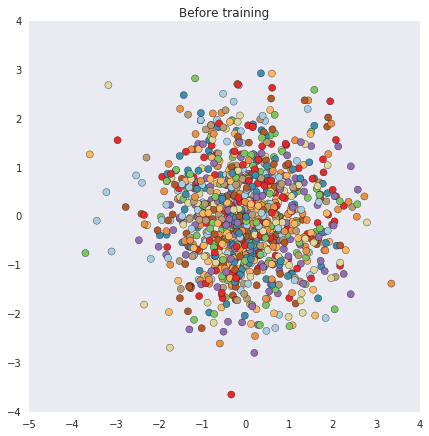

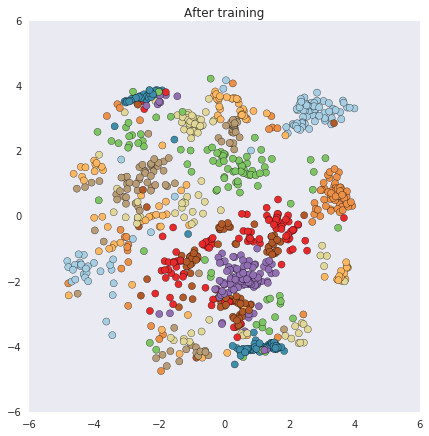

In [9]:
# Plot the latent locations before and after training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid('off')
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid('off')
plt.scatter(x=lips_[-1, :, 0], y=lips_[-1, :, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

## Draw samples conditioned on the data and latent embeddings
We sample at 100 points on a 2-d grid in the latent space.

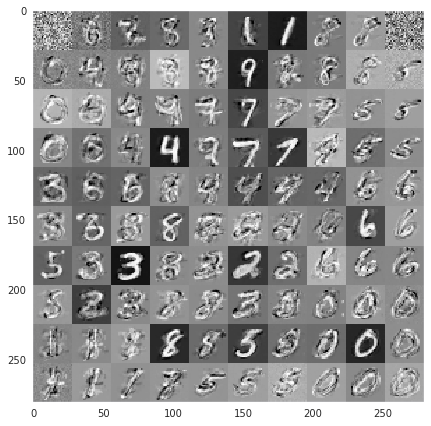

In [10]:
samples_ = sess.run(samples)

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples_)
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid('off')
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()

## Conclusion
We've taken a brief tour of the Gaussian process latent variable model, and
shown how we can implement it in just a few lines of TF and TF Probability
code.